In [1]:
import h5py
import numpy as np
import meshio

import matplotlib.pyplot as plt

#Set fonts
from matplotlib import rc, rcParams, cm
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Arial']})

In [2]:
# Plotting function
def PlotLine(y = 2*56.25/25.4, x = 1.5*56.25/25.4, dpi=100):
    fig, ax = plt.subplots(figsize=(y, x), dpi=dpi, tight_layout=True)
    return ax

In [3]:
def getTopY_DOFs(mesh, ly, nDim):
    
    topY_DOFs = []

    # Number of nodes
    nNodes = mesh.points.shape[0]  
    # Node coordinates
    nodeCoord = mesh.points

    for iNod in range(nNodes):
        # top nodes
        if nodeCoord[iNod][1]==ly:
            topY_DOFs.append(nDim*iNod + 1)
    
    return topY_DOFs

In [4]:
# Read nodes and node coordinate from mesh file
mesh = meshio.read("../SENT.inp")

In [5]:
dofyt = int(2*5+1)
dofyb = int(2*2+1)

nSteps = 200
topY_DOFs = getTopY_DOFs(mesh, 52e-3, 2)
force_y = np.zeros((nSteps))
disp_y = np.zeros((nSteps))
CMOD = np.zeros((nSteps))

In [6]:

with h5py.File("Mech_SENT_EPTH_out.hdf5", "a") as fh5:
    
    for iStep in range(nSteps):
        
        force_y[iStep] = fh5["Force/Step_"+str(iStep)][()][topY_DOFs].sum()*12.5e-3
        disp_y[iStep] = fh5["Disp/Step_"+str(iStep)][()][topY_DOFs].sum()/len(topY_DOFs)
        yt = fh5["Disp/Step_"+str(iStep)][()][dofyt]
        yb = fh5["Disp/Step_"+str(iStep)][()][dofyb]
        CMOD[iStep] = yt-yb


Text(0, 0.5, 'Force (kN)')

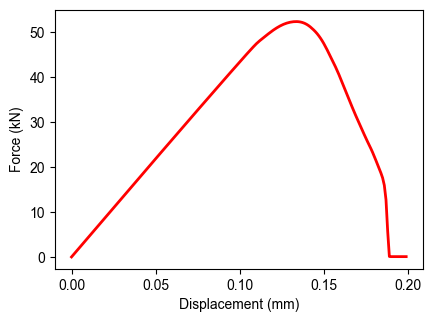

In [7]:
ax = PlotLine()

ax.plot(disp_y*1000, force_y/1000,"r", lw=2)

ax.set_xlabel("Displacement (mm)")
ax.set_ylabel("Force (kN)")

# plt.savefig("sig_h.svg", transparent=True)

Text(0, 0.5, 'Force (kN)')

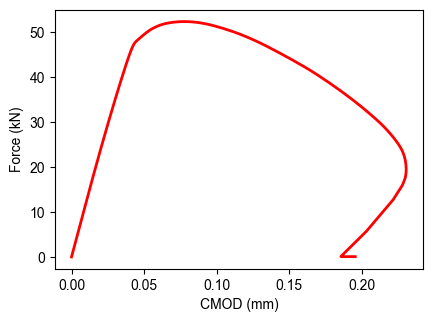

In [8]:
ax = PlotLine()

ax.plot(CMOD*1000, force_y/1000,"r", lw=2)

ax.set_xlabel("CMOD (mm)")
ax.set_ylabel("Force (kN)")

# plt.savefig("sig_h.svg", transparent=True)

In [28]:
c = 0.5
cbar = c/(0.5+c)
alpha = 1-cbar
beta = 1-alpha

In [29]:
alpha * 5 + beta * 6

5.5

Short answer: **No**—using a Macaulay alone on (c/c_c) only clips the **negative** side ((\langle x\rangle=\max(x,0))); it does **not** cap at 1.
So (\langle c/c_c\rangle) can still exceed 1 when (c>c_c).

### Do this instead (simple & safe)

* **Blend weight (true DBT knob):**
  [
  \bar c ;=; \min!\Big(1,\max!\big(0,\tfrac{c}{c_c}\big)\Big)
  \quad\text{(i.e., clamp to }[0,1]\text{)}
  ]

* **With toughness weakening (keep it minimal):**
  [
  w_c(c);=; w_c^{0},\big(1-\alpha,\bar c_w\big),\qquad 0<\alpha<1,
  ]
  where you can take (\bar c_w=\bar c) (same pivot) or use a different cap (c_c^{(w)}).

* **Driving force with your elegant blend + weakening:**
  [
  \tilde{\mathcal D}^{\mathrm{ep}}(c)
  =\zeta\left\langle
  \dfrac{\bar c,\tilde{\psi}^{e+} + (1-\bar c),\tilde w^{p}}
  {,w_c(c),}-1
  \right\rangle,
  \qquad
  \mathcal H(t)=\max_{s\le t}\big[0,\tilde{\mathcal D}^{\mathrm{ep}}(c(s))\big].
  ]

That’s it: clamp (\bar c) (not Macaulay-only), optionally weaken (w_c) with the **same** or a **separate** capped weight. Keeps everything physical, bounded, and still dead simple.
